In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.utils import resample
from scipy.stats import truncnorm

rng = np.random.default_rng(seed=42)

In [66]:
# === Load Forecast Results from CSV File ===
# This reloads the previously exported model forecast and confidence intervals.
# File: output/02_parcel_volumens_estimation_complete.csv
# Contains: Yearly predictions for linear, logistic, and exponential models with 95% CI.

forecast_df = pd.read_csv("output/02_parcel_volumen_estimation_complete.csv")
model_predictions_df = pd.read_csv("output/02_forecast_only_model_predictions.csv")

In [12]:
# === Load Parcel Volume Data from Excel ===

# =============================================================================
# Weekly Parcel Volume Data – Based on Swiss Post (2019–2021)
# -----------------------------------------------------------------------------
# The data used in this analysis is derived from the publication:
#
# Gottschalk, Felix & Lehmann, Alexandra (2023). 
# "Covid-19 and Swiss Post: Volume Developments and the Economic Value of Postal Service, 
# in the Pandemic and Beyond." In: *The Future of Postal Services in a Digital World*, 
# pp. 207–222. Springer. DOI: 10.1007/978-3-031-11413-7_14
#
# Note:
# This dataset reflects weekly parcel volumes in Switzerland and was used as a proxy
# due to the absence of published weekly parcel data for Germany.
# The relative seasonal trends are assumed to be similar and provide a reasonable approximation.
# =============================================================================


# Define the path to the Excel file
file_path = "input/Parcels19_20_21_inter.xlsx"

# Load the Excel workbook
xls = pd.ExcelFile(file_path)

# Read the worksheet named 'Tabelle1'
df1 = pd.read_excel(xls, sheet_name='Tabelle1')


# === Clean and Prepare the DataFrame ===

# Skip the first row (header or notes), and keep only the first 4 columns (Week + years)
df1_cleaned = df1.iloc[1:, :4]

# Rename columns for clarity
df1_cleaned.columns = ["Week", "2019", "2020", "2021"]

# Convert data types for numeric operations
df1_cleaned = df1_cleaned.astype({
    "Week": int,
    "2019": float,
    "2020": float,
    "2021": float
})


# === Calculate Average Annual Volume for Each Year ===

# These average values will be used to normalize weekly patterns
df1_cleaned["avg_2019"] = df1_cleaned["2019"].mean()
df1_cleaned["avg_2020"] = df1_cleaned["2020"].mean()
df1_cleaned["avg_2021"] = df1_cleaned["2021"].mean()


# === Calculate Relative Weekly Volume ===

# Each week's volume is divided by the annual average to produce relative indicators
# This normalizes seasonality across years
df1_cleaned["rel_2019"] = df1_cleaned["2019"] / df1_cleaned["avg_2019"]
df1_cleaned["rel_2020"] = df1_cleaned["2020"] / df1_cleaned["avg_2020"]
df1_cleaned["rel_2021"] = df1_cleaned["2021"] / df1_cleaned["avg_2021"]


# === Ensure All Relative Values Are Numeric ===

# Coerce any non-numeric values (e.g., NaNs or bad entries) to proper float type
df1_cleaned[["rel_2019", "rel_2020", "rel_2021"]] = df1_cleaned[[
    "rel_2019", "rel_2020", "rel_2021"
]].apply(pd.to_numeric, errors='coerce')


# === Drop Week 53 if Present (Not All Years Have It) ===

# To ensure consistency across years, remove week 53
df1_cleaned = df1_cleaned[df1_cleaned.Week < 53]


# === Add Weekly Time Index (Datetime Format) ===

# Create a datetime index starting from the first week of 2020
df1_cleaned["date_index"] = pd.date_range(
    start="2020-01-01", periods=52, freq="W"
)

# Set the datetime index for time series plotting and analysis
df1_cleaned.set_index("date_index", inplace=True)


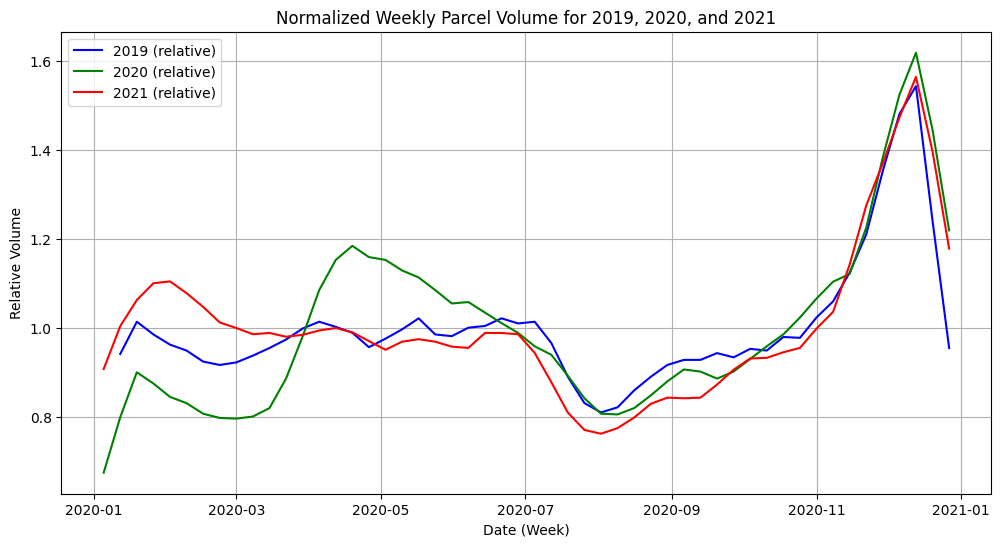

In [13]:
# === Plot Relative Weekly Parcel Volumes for 2019, 2020, and 2021 ===

# Create a new figure with specified width and height
plt.figure(figsize=(12, 6))

# Plot the normalized weekly values for each year
plt.plot(
    df1_cleaned.index, df1_cleaned["rel_2019"],
    label="2019 (relative)", color="blue"
)
plt.plot(
    df1_cleaned.index, df1_cleaned["rel_2020"],
    label="2020 (relative)", color="green"
)
plt.plot(
    df1_cleaned.index, df1_cleaned["rel_2021"],
    label="2021 (relative)", color="red"
)

# Add axis labels and plot title
plt.xlabel("Date (Week)")
plt.ylabel("Relative Volume")
plt.title("Normalized Weekly Parcel Volume for 2019, 2020, and 2021")

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


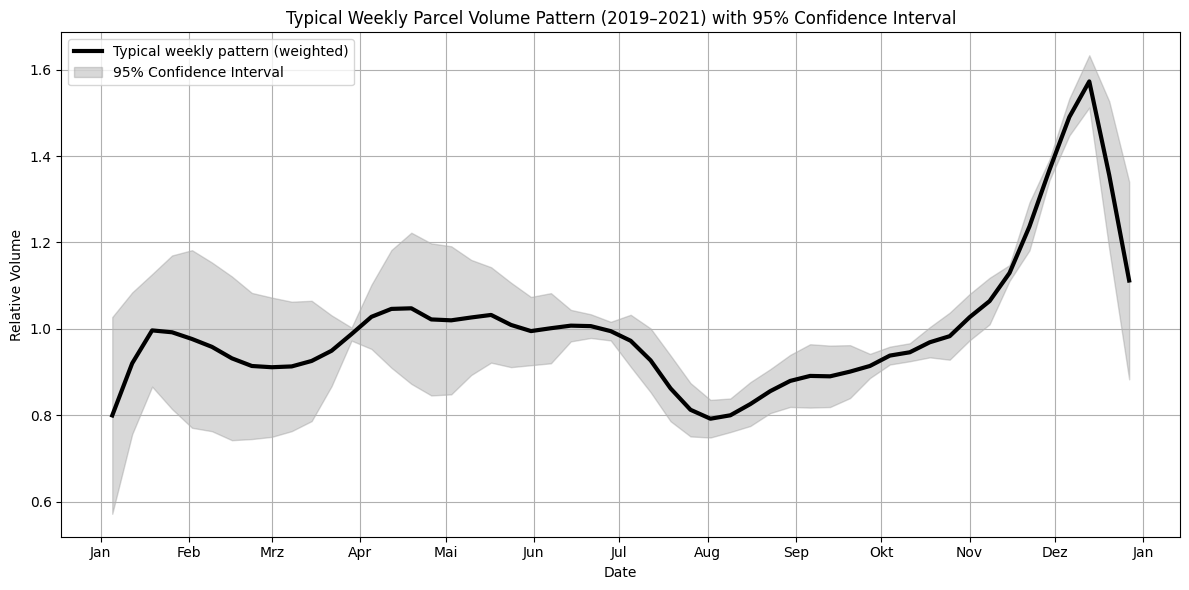

In [18]:
# === Function to Calculate Weighted Mean and Confidence Interval ===
def compute_weighted_mean_ci(
    row, 
    weights={"rel_2019": 0.35, "rel_2020": 0.3, "rel_2021": 0.35}
):
    """
    Computes a weighted average, standard deviation, and 95% confidence interval
    from the relative weekly parcel values for 2019–2021.

    Parameters:
    -----------
    row : pd.Series
        A row from df1_cleaned containing rel_2019, rel_2020, rel_2021
    weights : dict
        Dictionary specifying the weight for each year

    Returns:
    --------
    pd.Series with:
        - mean: weighted average
        - std: weighted standard deviation
        - ci_lower: lower bound of 95% confidence interval
        - ci_upper: upper bound of 95% confidence interval
    """
    # Extract values and weights
    values = np.array([row["rel_2019"], row["rel_2020"], row["rel_2021"]])
    weights_array = np.array([
        weights["rel_2019"], weights["rel_2020"], weights["rel_2021"]
    ])

    # Exclude missing values (NaNs)
    valid = ~np.isnan(values)
    if valid.sum() == 0:
        return pd.Series({"mean": np.nan, "std": np.nan, "ci_lower": np.nan, "ci_upper": np.nan})

    # Compute weighted mean
    weighted_mean = np.average(values[valid], weights=weights_array[valid])

    # Compute weighted standard deviation
    weighted_variance = np.average(
        (values[valid] - weighted_mean) ** 2, weights=weights_array[valid]
    )
    weighted_std = np.sqrt(weighted_variance)

    # Compute 95% confidence interval (±1.96 × std)
    ci_lower = weighted_mean - 1.96 * weighted_std
    ci_upper = weighted_mean + 1.96 * weighted_std

    return pd.Series({
        "mean": weighted_mean,
        "std": weighted_std,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    })


# === Apply the Function to All Weekly Rows ===
df_ci = df1_cleaned.apply(compute_weighted_mean_ci, axis=1)


# === Plot: Typical Weekly Pattern with Confidence Interval ===
plt.figure(figsize=(12, 6))

# Plot the weighted average weekly curve
plt.plot(
    df1_cleaned.index, df_ci["mean"],
    label="Typical weekly pattern (weighted)", linewidth=3, color="black"
)

# Plot the 95% confidence interval as shaded area
plt.fill_between(
    df1_cleaned.index,
    df_ci["ci_lower"],
    df_ci["ci_upper"],
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)

# Add labels and styling
plt.xlabel("Date")
plt.ylabel("Relative Volume")
plt.title("Typical Weekly Parcel Volume Pattern (2019–2021) with 95% Confidence Interval")
# Format x-axis to show months only
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Short month names (Jan, Feb, ...)

# Additional styling
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# ==============================================================================
# 📦 Stochastic Simulation of Weekly Parcel Volume Patterns with Seasonal Tuning
# ------------------------------------------------------------------------------
# This code implements a Genetic Algorithm (GA) using DEAP to optimize parameters
# for simulating realistic weekly parcel volume trajectories.
#
# ✅ Objective:
# - Generate synthetic weekly curves that reflect the empirical "typical year"
#   (df_ci["mean"]) based on observed data from 2019–2021.
# - Apply special weighting to November and December to better capture 
#   Christmas-related seasonal spikes and post-peak declines.
#
# 🧬 Genetic Algorithm:
# - Optimizes 6 parameters:
#     1. alpha_base: inertia factor for autoregression
#     2. random_scale: baseline noise level
#     3. xmas_boost_factor: uplift multiplier during peak weeks
#     4. xmas_reduction_factor: dampening multiplier post-Christmas
#     5. xmas_start_week: beginning of seasonal peak
#     6. xmas_end_week: end of seasonal peak
# - Fitness function penalizes error (MSE) across the year,
#   with extra penalty for November–December deviations (3× weight).
#
# 📈 Output:
# - Best parameter set from the GA is used to simulate multiple yearly paths.
# - A final plot shows these stochastic trajectories compared to the 
#   original weighted seasonal pattern and its confidence interval.
#
# 💡 Note:
# - The whole block is currently commented out (for performance reasons).
# - Can be reactivated as needed to rerun simulations or tweak assumptions.
# ==============================================================================


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from deap import base, creator, tools, algorithms

# # === GA Einstellungen ===
# num_simulations = 100  # Anzahl der Monte-Carlo-Simulationen
# num_generations = 50   # Anzahl der Generationen
# pop_size = 20          # Größe der Population

# # Ziel: df_ci["mean"]
# target_mean = df_ci["mean"].values

# # ** Gewichtungsfaktor für November & Dezember**
# weight_nov_dec = 3.0  # Fehler im November & Dezember wird dreifach gewichtet

# # **Fitness-Funktion (Minimierung des Fehlers)**
# def evaluate(individual):
#     alpha_base, random_scale, xmas_boost_factor, xmas_reduction_factor, xmas_start_week, xmas_end_week = individual

#     # ** Sicherstellen, dass Werte sinnvoll sind**
#     random_scale = max(0.001, random_scale)  # Noise ≥ 0.001
#     alpha_base = max(0.5, alpha_base)  # alpha_base ≥ 0.5
#     xmas_start_week = int(round(xmas_start_week))
#     xmas_end_week = int(round(xmas_end_week))
#     xmas_reduction_factor = min(1.0, max(0.3, xmas_reduction_factor))  # Faktor zwischen 0.3 und 1.0

#     simulated_years = np.zeros((num_simulations, len(df_ci)))

#     for i in range(num_simulations):
#         sampled_trajectory = np.zeros(len(df_ci))
#         sampled_trajectory[0] = rng.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])

#         for t in range(1, len(df_ci)):
#             week_num = df_ci.index[t].week

#             if xmas_start_week <= week_num <= xmas_end_week:
#                 alpha = alpha_base + 0.2  
#                 scale_factor = xmas_boost_factor  
#             elif week_num > xmas_end_week:  # Reduktion nach Weihnachten!
#                 alpha = alpha_base
#                 scale_factor = xmas_reduction_factor
#             else:
#                 alpha = alpha_base
#                 scale_factor = 1.0

#             sampled_trajectory[t] = (
#                 alpha * sampled_trajectory[t-1] +  
#                 (1 - alpha) * rng.normal(df_ci["mean"].iloc[t] * scale_factor, df_ci["std"].iloc[t]) +
#                 rng.normal(0, random_scale)
#             )

#         simulated_years[i, :] = sampled_trajectory

#     # Mittelwert über alle Simulationen berechnen
#     mean_simulation = np.mean(simulated_years, axis=0)

#     # ** MSE mit Gewichtung für November & Dezember**
#     mse = np.mean((mean_simulation - target_mean) ** 2)
    
#     # **Fix: Extraktion der November & Dezember Indizes als Integer-Maske**
#     nov_dec_mask = (df_ci.index.month == 11) | (df_ci.index.month == 12)
#     mse_nov_dec = np.mean((mean_simulation[nov_dec_mask] - target_mean[nov_dec_mask]) ** 2)

#     total_loss = mse + weight_nov_dec * mse_nov_dec  # November & Dezember 3x gewichtet
    
#     return (total_loss,)  # Minimierung

# # === 🧬 Genetischer Algorithmus einrichten ===
# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimierung
# creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()
# toolbox.register("attr_alpha", rng.uniform, 0.5, 0.8)  # Alpha-Bereich (min 0.5)
# toolbox.register("attr_noise", rng.uniform, 0.001, 0.05)  # Noise ≥ 0.001
# toolbox.register("attr_xmas", rng.uniform, 1.1, 2.0)  # Weihnachts-Boost
# toolbox.register("attr_xmas_reduction", rng.uniform, 0.3, 1.0)  # Weihnachts-Reduktion nach Peak
# toolbox.register("attr_xmas_start", rng.uniform, 40, 48)  # Start zwischen Woche 40 und 48
# toolbox.register("attr_xmas_end", rng.uniform, 49, 52)  # Ende zwischen Woche 49 und 52

# toolbox.register("individual", tools.initCycle, creator.Individual, 
#                  (toolbox.attr_alpha, toolbox.attr_noise, toolbox.attr_xmas, toolbox.attr_xmas_reduction, toolbox.attr_xmas_start, toolbox.attr_xmas_end), n=1)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# toolbox.register("evaluate", evaluate)
# toolbox.register("mate", tools.cxBlend, alpha=0.5)
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)

# # ===  GA ausführen ===
# population = toolbox.population(n=pop_size)
# algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=True)

# # Beste Lösung extrahieren
# best_ind = tools.selBest(population, k=1)[0]
# alpha_opt, noise_opt, xmas_opt, xmas_reduction_opt, xmas_start_opt, xmas_end_opt = best_ind
# print(f"Optimierte Parameter: alpha_base={alpha_opt:.3f}, random_scale={noise_opt:.3f}, xmas_boost_factor={xmas_opt:.3f}, xmas_reduction_factor={xmas_reduction_opt:.3f}, xmas_start_week={int(xmas_start_opt)}, xmas_end_week={int(xmas_end_opt)}")

# # ===  Finale Simulation mit optimierten Parametern ===
# simulated_years_opt = pd.DataFrame(index=df_ci.index)
# for i in range(num_simulations):
#     sampled_trajectory = np.zeros(len(df_ci))
#     sampled_trajectory[0] = rng.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])

#     for t in range(1, len(df_ci)):
#         week_num = df_ci.index[t].week

#         if int(xmas_start_opt) <= week_num <= int(xmas_end_opt):
#             alpha = alpha_opt + 0.2  
#             scale_factor = xmas_opt  
#         elif week_num > int(xmas_end_opt):  # 🎯 Reduktion nach Weihnachten!
#             alpha = alpha_opt
#             scale_factor = xmas_reduction_opt
#         else:
#             alpha = alpha_opt
#             scale_factor = 1.0

#         sampled_trajectory[t] = (
#             alpha * sampled_trajectory[t-1] +  
#             (1 - alpha) * rng.normal(df_ci["mean"].iloc[t] * scale_factor, df_ci["std"].iloc[t]) +
#             rng.normal(0, max(0.001, noise_opt))
#         )

#     simulated_years_opt[f"Simulation_{i+1}"] = sampled_trajectory

# # ===  Visualisierung ===
# plt.figure(figsize=(12, 6))

# for i in range(num_simulations):
#     plt.plot(df_ci.index, simulated_years_opt[f"Simulation_{i+1}"], alpha=0.05, color="blue")

# plt.plot(df_ci.index, df_ci["mean"], color="black", linewidth=2, label="Ziel-Mittelwert")
# plt.fill_between(df_ci.index, df_ci["ci_lower"], df_ci["ci_upper"], color="grey", alpha=0.3, label="95%-CI")

# plt.xlabel("Datum")
# plt.ylabel("Relativer Wert")
# plt.title("Optimierte stochastische Jahresverläufe mit verbesserter Gewichtung für November & Dezember")
# plt.legend()
# plt.grid(True)
# plt.show()


In [20]:
# ===  Optimierte Parameter aus GA ===
alpha_opt = 0.576
noise_opt = 0.014
xmas_opt = 1.266
xmas_reduction_opt = 0.749
xmas_start_opt = 45
xmas_end_opt = 50

In [100]:
df_ci

,mean,std,ci_lower,ci_upper
date_index,,,,
2020-01-05,0.799561,0.116170,0.571868,1.027255
2020-01-12,0.920254,0.083700,0.756201,1.084307
2020-01-19,0.996446,0.066465,0.866176,1.126717
2020-01-26,0.992076,0.090757,0.814192,1.169960
2020-02-02,0.976545,0.104887,0.770966,1.182123
2020-02-09,0.958320,0.099632,0.763042,1.153599
2020-02-16,0.931786,0.096712,0.742232,1.121341
2020-02-23,0.914048,0.086317,0.744866,1.083230
2020-03-01,0.911172,0.082265,0.749931,1.072412


In [ ]:
from scipy.stats import truncnorm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Helper: Truncated normal sampling ===
def truncated_normal_sample(mu, std, lower, upper, rng):
    """
    Samples a value from a truncated normal distribution.

    Parameters:
    -----------
    mu : float
        Mean of the distribution.
    std : float
        Standard deviation of the distribution.
    lower : float
        Lower bound for truncation.
    upper : float
        Upper bound for truncation.
    rng : np.random.Generator
        Random number generator for reproducibility.

    Returns:
    --------
    float
        Sampled value within [lower, upper].
    """
    if std <= 0 or not np.isfinite(std):
        return mu
    std = max(std, 1e-6)  # Ensure positive std

    # Transform bounds to standard normal
    a, b = (lower - mu) / std, (upper - mu) / std
    return truncnorm.rvs(a, b, loc=mu, scale=std, random_state=rng)

# === Yearly fluctuation: AR(1) type process ===
def simulate_yearly_fluctuations_AR1(years, rng, mu=1.0, phi=0.85, sigma=0.02, lower=0.9, upper=1.1):
    """
    Simulates multiplicative year-level fluctuations using an AR(1) process.

    Parameters:
    -----------
    years : array-like
        Years for which fluctuations are simulated.
    rng : np.random.Generator
        Random number generator.
    mu : float
        Long-term mean multiplier (e.g. 1.0 = neutral).
    phi : float
        Autoregressive memory term (0 = memoryless, 1 = persistent).
    sigma : float
        Std deviation of noise term (uncertainty size).
    lower, upper : float
        Clipping bounds for extreme fluctuations.

    Returns:
    --------
    dict
        Mapping of year to multiplicative fluctuation value.
    """
    fluctuations = []
    last_value = mu

    for year in years:
        epsilon = rng.normal(0, sigma)
        new_value = phi * last_value + (1 - phi) * mu + epsilon
        new_value = np.clip(new_value, lower, upper)
        fluctuations.append(new_value)
        last_value = new_value

    return dict(zip(years, fluctuations))


# === Simulate AR(1) fluctuations for forecast years ===
years_future = np.arange(2029, 2051)
yearly_fluctuation_map = simulate_yearly_fluctuations_AR1(
    years=forecast_df[forecast_df["year"] > 2028]["year"].unique(),
    rng=rng,
    mu=1.0,
    phi=0.6,       # Moderate memory
    sigma=0.01,    # ~±1% per year
    lower=0.95,
    upper=1.05
)

# --- Step 1: Prepare weekly profile (seasonality) ---
# The reduction_factor for Week 53 is based on the empirical data from 2021 (Swiss Data) and used for all years with 53 weeks
base_volume = 772000
reduced_volume = 638000
reduction_factor = (base_volume - reduced_volume) / base_volume

# === Begin Monte Carlo Weekly Forecast Generation ===
weekly_forecast_ci = []

for _, row in forecast_df.iterrows():
    year = int(row["year"])
    num_weeks = int(row["weeks_in_year"])

    df_ci_extended = df_ci.copy()

    if num_weeks > len(df_ci):
        # Add week 53 based on reduced week 52 value
        week_53 = {
            "mean": df_ci["mean"].iloc[51] * (1 - reduction_factor),
            "ci_lower": df_ci["ci_lower"].iloc[51],
            "ci_upper": df_ci["ci_upper"].iloc[51]
        }
        df_ci_extended = pd.concat([df_ci, pd.DataFrame([week_53])], ignore_index=True)

    # Extract week-level distributions
    weekly_mean = df_ci_extended["mean"].iloc[:num_weeks].to_numpy()
    weekly_lower = df_ci_extended["ci_lower"].iloc[:num_weeks].to_numpy()
    weekly_upper = df_ci_extended["ci_upper"].iloc[:num_weeks].to_numpy()

    # --- Step 2: Weekly timestamp generation ---
    week_dates = pd.date_range(
        start=f"{year}-01-04",  # Jan 4 = always within ISO week 1
        periods=num_weeks,
        freq="W-MON"
    )

    # Initialize year DataFrame
    temp_df = pd.DataFrame({
        "Date": week_dates,
        "Year": year,
        "WeeklyMean": weekly_mean,
        "WeeklyLower": weekly_lower,
        "WeeklyUpper": weekly_upper
    })

    # --- Step 3: Simulate forecast for each model ---
    for model_name in ["linear", "logistic", "exponential"]:
        model_value = row[model_name]

        # Initialize trajectory (autoregressive)
        sampled_trajectory = np.zeros(num_weeks)
        sampled_trajectory[0] = rng.normal(df_ci["mean"].iloc[0], df_ci["std"].iloc[0])

        for t in range(1, num_weeks):
            if t > 51:
                # Use last week's profile for week 53 with optional reduction
                mean_value = df_ci["mean"].iloc[51] * (1 - reduction_factor)
                std_value = df_ci["std"].iloc[51]
            else:
                mean_value = df_ci["mean"].iloc[t]
                std_value = df_ci["std"].iloc[t]

            # Holiday boost
            if xmas_start_opt <= t <= xmas_end_opt:
                alpha = alpha_opt + 0.2
                scale_factor = xmas_opt
            elif t > xmas_end_opt:
                alpha = alpha_opt
                scale_factor = xmas_reduction_opt
            else:
                alpha = alpha_opt
                scale_factor = 1.0

            # Autoregressive + noisy dynamics
            sampled_trajectory[t] = (
                alpha * sampled_trajectory[t-1] +
                (1 - alpha) * rng.normal(mean_value * scale_factor, std_value) +
                rng.normal(0, max(0.001, noise_opt))
            )

        # --- Step 4: Apply model forecast and uncertainty scaling ---

        # Option 1️⃣ — Pure deterministic model value (default)
        # sampled_trajectory *= model_value

        # Option 2️⃣ — Multiply with sampled model value from its confidence interval
        # Useful if you want to reflect model *parameter uncertainty* in the trajectory
        # sampled_model_value = truncated_normal_sample(mu, std, lower, upper, rng)
        # sampled_trajectory *= sampled_model_value

        # Option 3️⃣ — Multiply with model + yearly AR(1) fluctuation
        # Reflects that future years may deviate slightly due to real-world volatility
        yearly_fluctuation = yearly_fluctuation_map.get(year, 1.0)
        sampled_trajectory *= model_value * yearly_fluctuation

        # --- Step 5: Store results per model ---
        temp_df[f"{model_name}_Prognose"] = sampled_trajectory
        temp_df[f"{model_name}_CI_Lower"] = weekly_lower * row[f"ci_lower_{model_name}"]
        temp_df[f"{model_name}_CI_Upper"] = weekly_upper * row[f"ci_upper_{model_name}"]
        temp_df[f"{model_name}_Mean_Typical"] = weekly_mean * row[model_name]

    # Add to main list
    weekly_forecast_ci.append(temp_df)

# === Final Concatenation of All Weekly Forecasts ===
weekly_forecast_ci_df = pd.concat(weekly_forecast_ci).reset_index(drop=True)

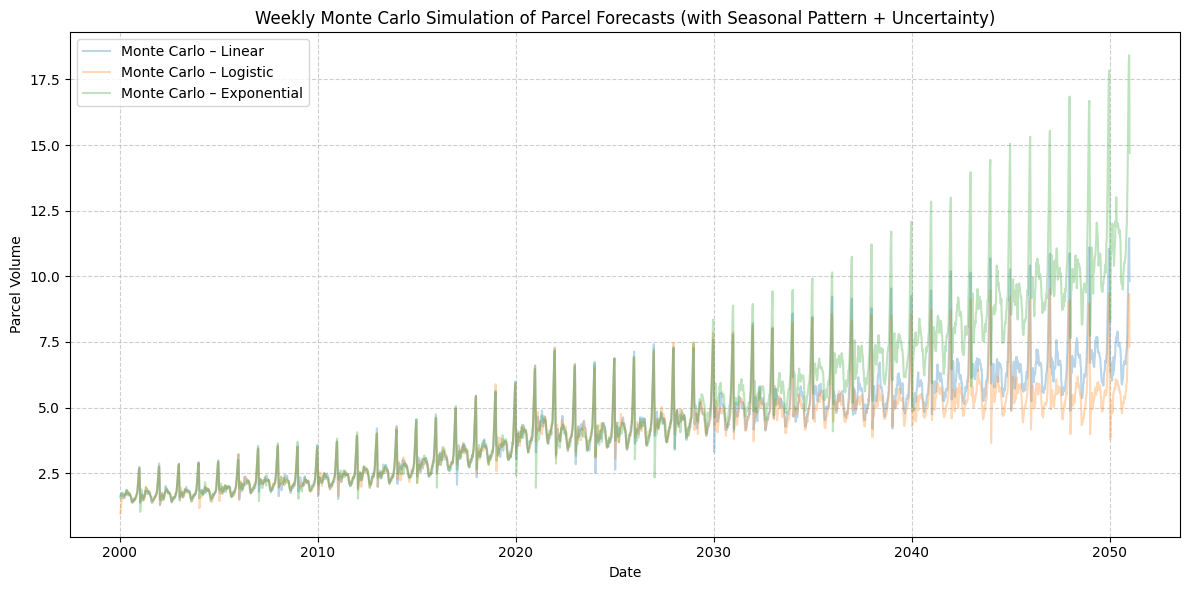

In [160]:
# === 📈 Visualization of Trajectories ===
plt.figure(figsize=(12, 6))

for model_name in ["linear", "logistic", "exponential"]:
    subset = weekly_forecast_ci_df[["Date", f"{model_name}_Prognose"]].dropna()
    plt.plot(subset["Date"], subset[f"{model_name}_Prognose"], alpha=0.3, label=f"Monte Carlo – {model_name.title()}")

plt.xlabel("Date")
plt.ylabel("Parcel Volume")
plt.title("Weekly Monte Carlo Simulation of Parcel Forecasts (with Seasonal Pattern + Uncertainty)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

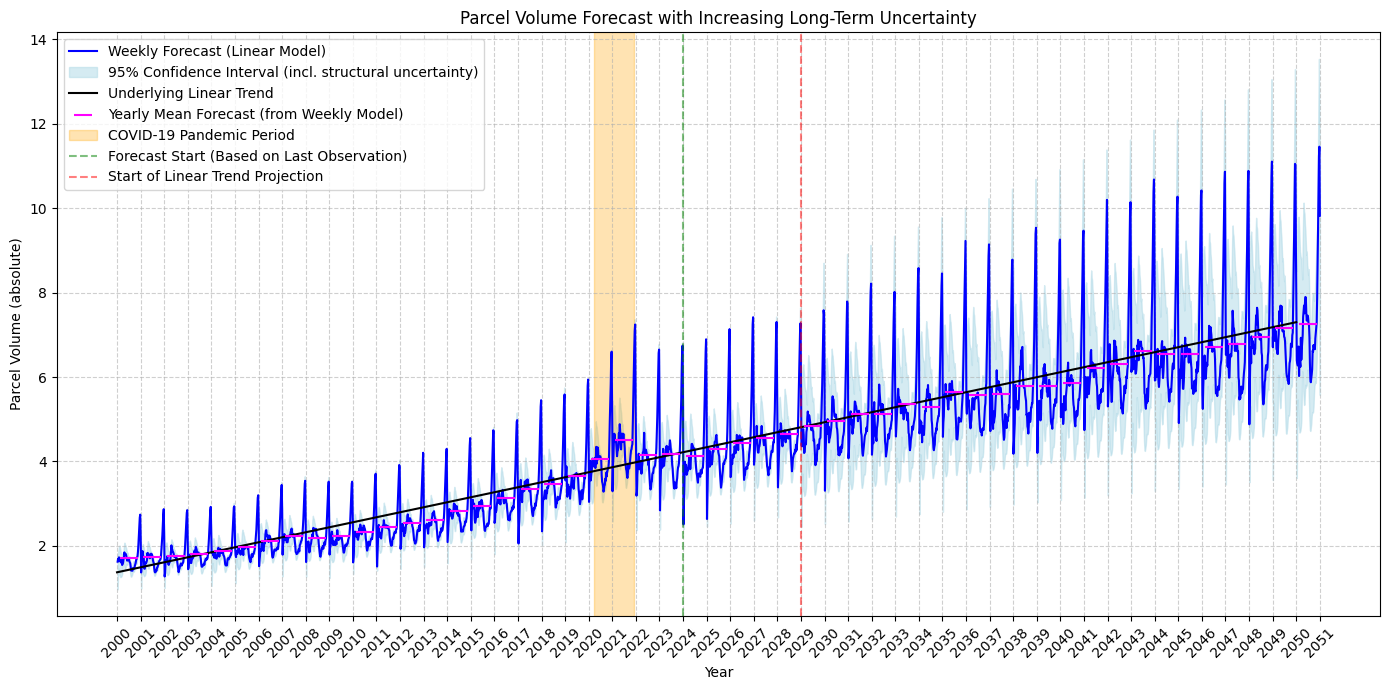

In [179]:
# === Weekly Parcel Volume Forecast Plot with Linear Model ===

years_forecast = np.arange(2000, 2051)

plt.figure(figsize=(14, 7))

# --- Plot 1: Weekly linear forecast (Monte Carlo mean trajectory) ---
plt.plot(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["linear_Prognose"],
    color="blue",
    label="Weekly Forecast (Linear Model)"
)

# --- Plot 2: Confidence Interval including long-term uncertainty ---
plt.fill_between(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["linear_CI_Lower"],
    weekly_forecast_ci_df["linear_CI_Upper"],
    color="lightblue",
    alpha=0.5,
    label="95% Confidence Interval (incl. structural uncertainty)"
)

# --- Plot 3: Underlying linear model prediction (annual level) ---
y_linear_forecast_data = model_predictions_df["linear_model_predicted"]
plt.plot(
    pd.to_datetime([f"{year}-01-01" for year in years_forecast]),
    y_linear_forecast_data,
    linestyle="-",
    color="black",
    label="Underlying Linear Trend"
)

# --- Plot 4: Annual average of weekly forecast (centered on July 1st) ---
plt.scatter(
    pd.to_datetime([f"{year}-07-01" for year in weekly_forecast_ci_df["Year"].unique()]),
    weekly_forecast_ci_df.groupby("Year")["linear_Prognose"].mean().values,
    color="magenta",
    marker="_",
    s=175,
    label="Yearly Mean Forecast (from Weekly Model)",
    zorder=10
)

# --- Highlight COVID-19 period (March 2020 to Nov 2021) ---
plt.axvspan(
    pd.Timestamp("2020-03-25"),
    pd.Timestamp("2021-11-25"),
    color="orange",
    alpha=0.3,
    label="COVID-19 Pandemic Period"
)

# --- Mark the start of forecasting phases ---
plt.axvline(
    pd.Timestamp("2023-12-31"),
    color="green",
    linestyle="--",
    label="Forecast Start (Based on Last Observation)",
    alpha = 0.5
)
plt.axvline(
    pd.Timestamp("2028-12-31"),
    color="red",
    linestyle="--",
    label="Start of Linear Trend Projection",
    alpha = 0.5
)

# === Axes Formatting ===
plt.xlabel("Year")
plt.ylabel("Parcel Volume (absolute)")
plt.title("Parcel Volume Forecast with Increasing Long-Term Uncertainty")

# Optional: Clean and readable yearly ticks
years_range = np.arange(2000, 2052)
plt.xticks(
    pd.to_datetime([f"{year}-01-01" for year in years_range]),
    years_range,
    rotation=45
)

# === Legend and Grid ===
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


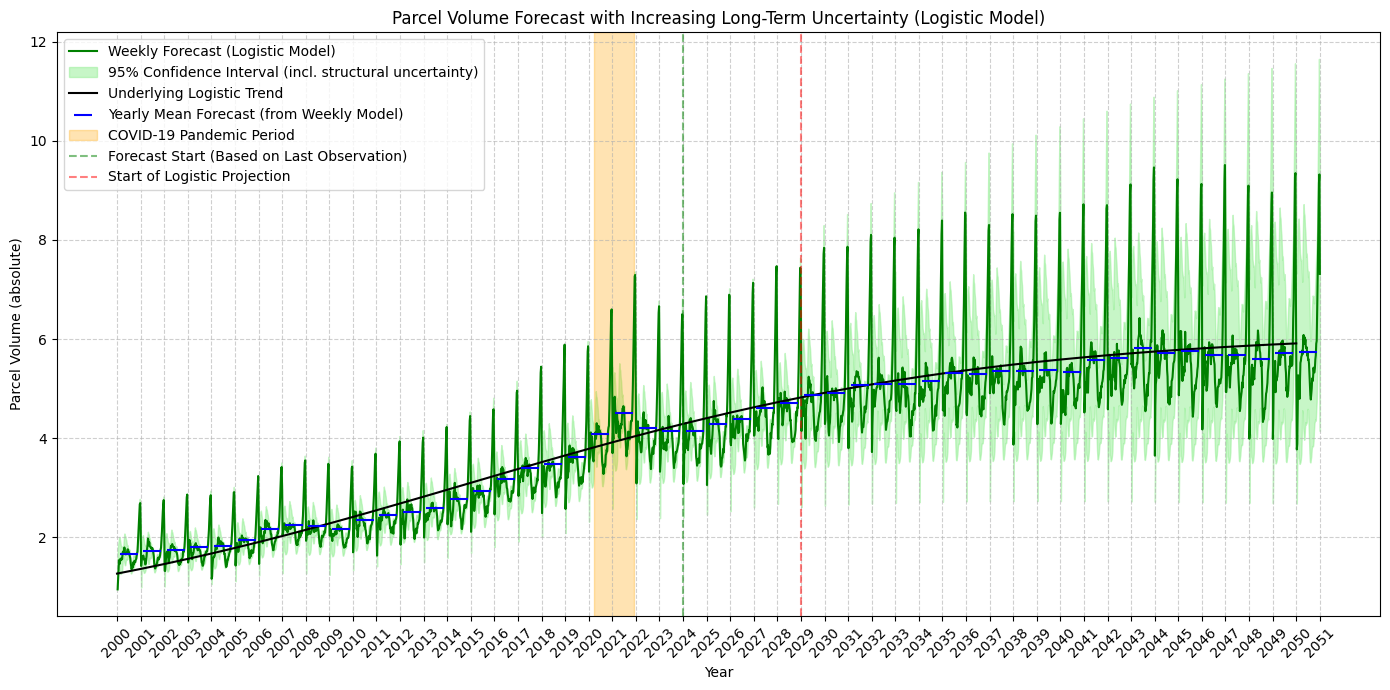

In [178]:
# === Weekly Parcel Volume Forecast Plot with Logistic Model ===

plt.figure(figsize=(14, 7))

# --- Plot 1: Weekly logistic forecast (Monte Carlo mean trajectory) ---
plt.plot(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["logistic_Prognose"],
    color="green",
    label="Weekly Forecast (Logistic Model)"
)

# --- Plot 2: Confidence Interval including long-term uncertainty ---
plt.fill_between(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["logistic_CI_Lower"],
    weekly_forecast_ci_df["logistic_CI_Upper"],
    color="lightgreen",
    alpha=0.5,
    label="95% Confidence Interval (incl. structural uncertainty)"
)

# --- Plot 3: Underlying logistic model prediction (annual level) ---
y_logistic_forecast_data = model_predictions_df["logistic_model_predicted"]
years_forecast = np.arange(2000, 2051)

plt.plot(
    pd.to_datetime([f"{year}-01-01" for year in years_forecast]),
    y_logistic_forecast_data,
    linestyle="-",
    color="black",
    label="Underlying Logistic Trend"
)

# --- Plot 4: Annual average of weekly forecast (centered on July 1st) ---
plt.scatter(
    pd.to_datetime([f"{year}-07-01" for year in weekly_forecast_ci_df["Year"].unique()]),
    weekly_forecast_ci_df.groupby("Year")["logistic_Prognose"].mean().values,
    color="blue",
    marker="_",
    s=175,
    label="Yearly Mean Forecast (from Weekly Model)",
    zorder=10
)

# --- Highlight COVID-19 period (March 2020 to Nov 2021) ---
plt.axvspan(
    pd.Timestamp("2020-03-25"),
    pd.Timestamp("2021-11-25"),
    color="orange",
    alpha=0.3,
    label="COVID-19 Pandemic Period"
)

# --- Mark the start of forecasting phases ---
plt.axvline(
    pd.Timestamp("2023-12-31"),
    color="green",
    linestyle="--",
    label="Forecast Start (Based on Last Observation)",
    alpha = 0.5
)
plt.axvline(
    pd.Timestamp("2028-12-31"),
    color="red",
    linestyle="--",
    label="Start of Logistic Projection",
    alpha = 0.5
)

# === Axes Formatting ===
plt.xlabel("Year")
plt.ylabel("Parcel Volume (absolute)")
plt.title("Parcel Volume Forecast with Increasing Long-Term Uncertainty (Logistic Model)")

# Define annual tick marks for better readability
years_range = np.arange(2000, 2052)
plt.xticks(
    pd.to_datetime([f"{year}-01-01" for year in years_range]),
    years_range,
    rotation=45
)

# === Legend and Grid ===
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


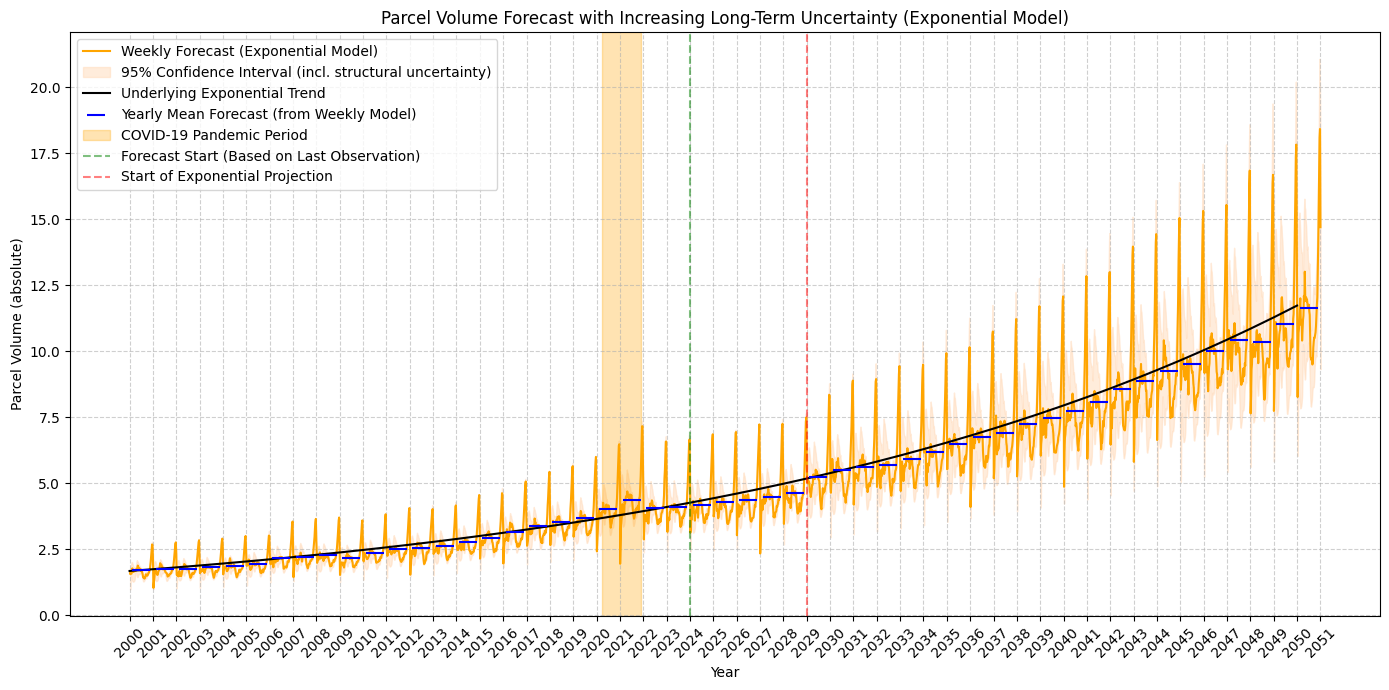

In [177]:
# === Weekly Parcel Volume Forecast Plot with Exponential Model ===

plt.figure(figsize=(14, 7))

# --- Plot 1: Weekly exponential forecast (Monte Carlo mean trajectory) ---
plt.plot(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["exponential_Prognose"],
    color="orange",
    label="Weekly Forecast (Exponential Model)"
)

# --- Plot 2: Confidence Interval including long-term uncertainty ---
plt.fill_between(
    weekly_forecast_ci_df["Date"],
    weekly_forecast_ci_df["exponential_CI_Lower"],
    weekly_forecast_ci_df["exponential_CI_Upper"],
    color="peachpuff",
    alpha=0.5,
    label="95% Confidence Interval (incl. structural uncertainty)"
)

# --- Plot 3: Underlying exponential model prediction (annual level) ---
y_exponential_forecast_data = model_predictions_df["exponential_model_predicted"]
years_forecast = np.arange(2000, 2051)

plt.plot(
    pd.to_datetime([f"{year}-01-01" for year in years_forecast]),
    y_exponential_forecast_data,
    linestyle="-",
    color="black",
    label="Underlying Exponential Trend"
)

# --- Plot 4: Annual average of weekly forecast (centered on July 1st) ---
plt.scatter(
    pd.to_datetime([f"{year}-07-01" for year in weekly_forecast_ci_df["Year"].unique()]),
    weekly_forecast_ci_df.groupby("Year")["exponential_Prognose"].mean().values,
    color="blue",
    marker="_",
    s=175,
    label="Yearly Mean Forecast (from Weekly Model)",
    zorder=10
)

# --- Highlight COVID-19 period (March 2020 to Nov 2021) ---
plt.axvspan(
    pd.Timestamp("2020-03-25"),
    pd.Timestamp("2021-11-25"),
    color="orange",
    alpha=0.3,
    label="COVID-19 Pandemic Period",
)

# --- Mark the start of forecasting phases ---
plt.axvline(
    pd.Timestamp("2023-12-31"),
    color="green",
    linestyle="--",
    label="Forecast Start (Based on Last Observation)",
    alpha = 0.5
)
plt.axvline(
    pd.Timestamp("2028-12-31"),
    color="red",
    linestyle="--",
    label="Start of Exponential Projection",
    alpha = 0.5
)

# === Axes Formatting ===
plt.xlabel("Year")
plt.ylabel("Parcel Volume (absolute)")
plt.title("Parcel Volume Forecast with Increasing Long-Term Uncertainty (Exponential Model)")

# Define annual tick marks for better readability
years_range = np.arange(2000, 2052)
plt.xticks(
    pd.to_datetime([f"{year}-01-01" for year in years_range]),
    years_range,
    rotation=45
)

# === Legend and Grid ===
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [180]:
weekly_forecast_ci_df.to_csv("output/03_yearly_weekly_parcel_forecast.csv", index=False)